# Section 7: Beyond Textbook Optimizers

In [1]:
import sys
sys.path.append("../postbound/postbound")

In [2]:
import json

from matplotlib import ticker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from postbound.db import postgres
from postbound.experiments import workloads
from postbound.vis import db as db_vis, plots

import analysis

In [3]:
results_base = "../datasets/04-beyond-textbook"
static_results_base = "../datasets/00-base"
workloads.workloads_base_dir = "../postbound/workloads"
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
sns.set_style("whitegrid")
sns.set_context("talk")

## General definitions

In [4]:
job, stats = workloads.job(), workloads.stats()
job, stats

(Workload: JOB (113 queries), Workload: Stats (146 queries))

In [5]:
def read_df(path: str, workload: workloads.Workload) -> pd.DataFrame:
    df = pd.read_csv(path, converters={"query_plan": analysis.load_pg_explain})
    df["label"] = pd.Categorical(df["label"], workload.labels(), ordered=True)
    return df

In [6]:
df_job = read_df(f"{results_base}/data-shift-job.csv", job)
df_stats = read_df(f"{results_base}/data-shift-stats.csv", stats)

In [7]:
df_job

,fill_ratio,plan_type,label,query,query_plan,total_runtime,timeout,db_config,server
0,1.0,native,1a,"SELECT MIN(mc.note) AS production_note, MIN(t....","EXPLAIN ANALYZE (plan time=0.002315, exec time...",0.150906,False,"{""system_name"": ""postgres"", ""system_version"": ...",ssd
1,1.0,native-fixed,1a,"SELECT MIN(mc.note) AS production_note, MIN(t....","EXPLAIN ANALYZE (plan time=0.002848, exec time...",0.187409,False,"{""system_name"": ""postgres"", ""system_version"": ...",ssd
2,1.0,robust-fixed,1a,"SELECT MIN(mc.note) AS production_note, MIN(t....",EXPLAIN ANALYZE (plan time=0.00223700000000000...,0.679818,False,"{""system_name"": ""postgres"", ""system_version"": ...",ssd
3,1.0,native,1b,"SELECT MIN(mc.note) AS production_note, MIN(t....",EXPLAIN ANALYZE (plan time=0.00110400000000000...,0.112567,False,"{""system_name"": ""postgres"", ""system_version"": ...",ssd
4,1.0,native-fixed,1b,"SELECT MIN(mc.note) AS production_note, MIN(t....",EXPLAIN ANALYZE (plan time=0.00153099999999999...,0.180586,False,"{""system_name"": ""postgres"", ""system_version"": ...",ssd
...,...,...,...,...,...,...,...,...,...
13103,0.2,robust-fixed,33b,"SELECT MIN(cn1.name) AS first_company, MIN(cn2...","EXPLAIN ANALYZE (plan time=0.064498, exec time...",0.132924,False,"{""system_name"": ""postgres"", ""system_version"": ...",hdd
13104,0.2,native,33c,"SELECT MIN(cn1.name) AS first_company, MIN(cn2...","EXPLAIN ANALYZE (plan time=0.078987, exec time...",0.093184,False,"{""system_name"": ""postgres"", ""system_version"": ...",hdd
13105,0.2,native-fixed,33c,"SELECT MIN(cn1.name) AS first_company, MIN(cn2...","EXPLAIN ANALYZE (plan time=0.109625, exec time...",1.164546,False,"{""system_name"": ""postgres"", ""system_version"": ...",hdd
13106,0.2,robust,33c,"SELECT MIN(cn1.name) AS first_company, MIN(cn2...","EXPLAIN ANALYZE (plan time=0.14126, exec time=...",0.290893,False,"{""system_name"": ""postgres"", ""system_version"": ...",hdd


## Figure 12: Performance of differen query plans during misestimations

In [8]:
def plot_distribution(df: pd.DataFrame, workload: workloads.Workload, label: str, *, server: str, out: str,
                      **fig_params) -> None:
    current_samples = df.query("label == @label & server == @server & plan_type.str.endswith('fixed')").copy()
    current_samples["plan_type"] = current_samples["plan_type"].map({"native-fixed": "PG native", "robust-fixed": "Robust (UES)"})
    current_samples["db_size"] = (current_samples["fill_ratio"] / 0.6) * 100

    fig, ax = plt.subplots(**fig_params)
    g = sns.lineplot(current_samples, x="db_size", y="total_runtime",
                     hue="plan_type", style="plan_type",
                     markers=True, dashes=False, ax=ax)
    g.axvline(100.0, color="grey", linestyle=":")
    g.set(xlabel="Database size", ylabel="Runtime [s]",
          title=f"{workload.name} query {label} ({server.upper()} server)")
    g.xaxis.set_major_formatter(ticker.PercentFormatter())
    g.legend(title="Optimizer type")

    fig.tight_layout()
    fig.savefig(out)

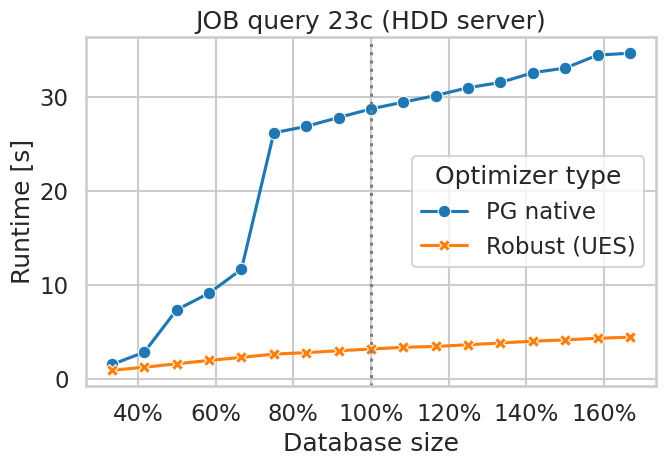

In [9]:
plot_distribution(df_job, job, "23c", server="hdd", out="plots/data-shift-23c.pdf")

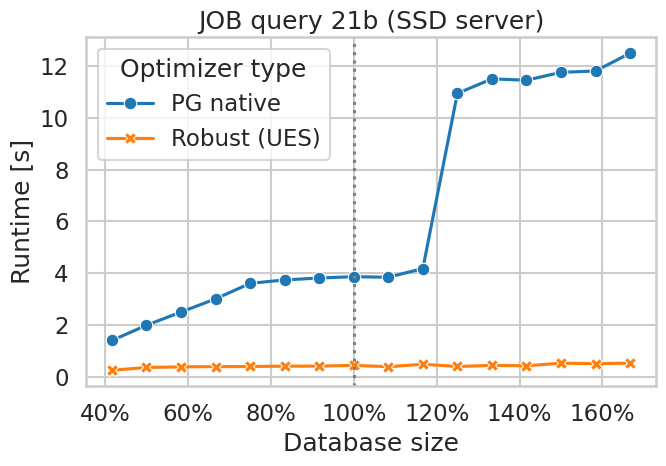

In [10]:
plot_distribution(df_job, job, "21b", server="ssd", out="plots/data-shift-21b.pdf")

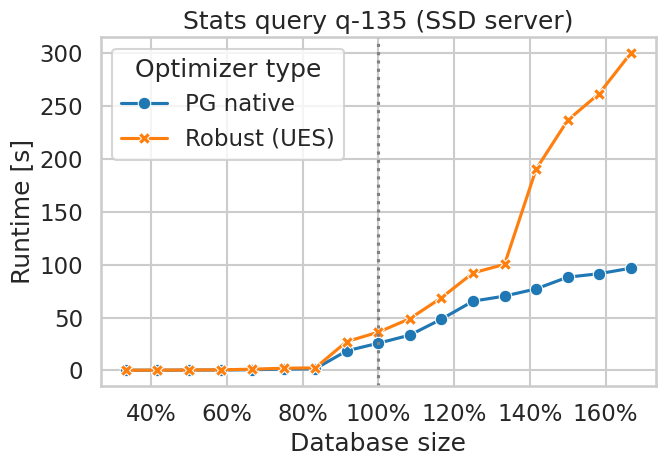

In [11]:
plot_distribution(df_stats, stats, "q-135", server="ssd", out="plots/stats-data-shift-q-135.pdf")

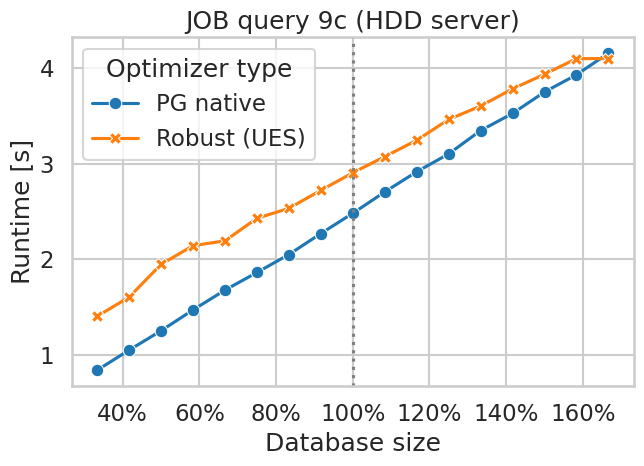

In [12]:
plot_distribution(df_job, job, "9c", server="hdd", out="plots/data-shift-9c.pdf")

## Table 4: Data shift results on the JOB

In [13]:
def linear_approx(fill_ratios: pd.Series, *, min_fr, max_fr, min_rt, max_rt) -> pd.Series:
    m = (max_rt - min_rt) / (max_fr - min_fr)
    n = min_rt - (m * min_fr)
    return m * fill_ratios + n

def determine_largest_jump(current_sample: pd.DataFrame) -> pd.Series:
    current_sample = current_sample.sort_values(by="fill_ratio").reset_index(drop=True)

    min_fill_ratio, max_fill_ratio = current_sample["fill_ratio"].min(), current_sample["fill_ratio"].max()
    min_rt = current_sample.query("fill_ratio == @min_fill_ratio")["total_runtime"].item()
    max_rt = current_sample.query("fill_ratio == @max_fill_ratio")["total_runtime"].item()

    approx_rts = linear_approx(current_sample["fill_ratio"], min_fr=min_fill_ratio, max_fr=max_fill_ratio, min_rt=min_rt, max_rt=max_rt)
    rt_deviation = current_sample["total_runtime"] - approx_rts

    jump_point = rt_deviation.abs().idxmax()
    expected_runtime = current_sample.at[jump_point, "total_runtime"]
    actual_runtime = approx_rts.loc[jump_point]
    jump_slowdown = max(expected_runtime, actual_runtime) / min(expected_runtime, actual_runtime)
    jump_fill_ratio = current_sample.at[jump_point, "fill_ratio"]
    return pd.Series(dict(jump_point=jump_fill_ratio, slowdown=jump_slowdown, min_rt=min_rt, max_rt=max_rt))


def make_jumps_df(df: pd.DataFrame) -> pd.DataFrame:
    jumps_df = (df
                .query("plan_type.str.endswith('fixed')")
                .groupby(["server", "plan_type", "label"], as_index=False, observed=True)
                .apply(determine_largest_jump, include_groups=False)
                .assign(rt_diff=lambda samples: samples["max_rt"] - samples["min_rt"])
                .sort_values(by=["server", "label", "plan_type"]))

    return jumps_df

In [14]:
jumps_job, jumps_stats = make_jumps_df(df_job), make_jumps_df(df_stats)

In [15]:
relevant_queries = jumps_job.query("rt_diff >= 1").groupby(["server", "plan_type"], as_index=True).size()
jumping_queries = jumps_job.query("rt_diff >= 1 & slowdown >= 1.3").groupby(["server", "plan_type"], as_index=True).size()
pd.DataFrame({"relevant_queries": relevant_queries, "jumping_queries": jumping_queries}, index=relevant_queries.index)

relevant_queries  jumping_queries
server plan_type                                      
hdd    native-fixed                73               65
       robust-fixed                85               33
ssd    native-fixed                66               55
       robust-fixed                63               17

## Numbers used throughout the text

**Share of jumps that happen during overestimation:**

In [16]:
# 0.6 is our reference point (i.e. DB size 100%). If there are less tuples in the DB (i.e. jump_point < reference), the
# optimizer over-estimated in the statistics. Otherwise, it under-estimated.

jump_pos = (jumps_job
            .query("rt_diff >= 1 & slowdown >= 1.3")
            .assign(jump_pos=lambda sample: np.where(sample["jump_point"] <= 0.6, "overest", "underest"))
            .groupby("jump_pos")
            .size())
1 - jump_pos.loc["underest"] / jump_pos.sum()

np.float64(0.8117647058823529)

## Figure 13: Execution time jumps of JOB query 21b

For this plot, the number of actual rows in the Materialize node is broken due to the loops performed as part of the nested-loop
joins: for each of the $6786731$ rows provided by the index scan on movie_keyword, another probe into to the materialize node is
performed. Since the materialize node contains $12$ rows in total (as emitted by the nested-loop join below), we end up with
$6786731 * 12 = 81440772$ rows.

In [17]:
samples_21b = df_job.query("label == '21b' & server == 'hdd' & plan_type == 'native-fixed'").reset_index(drop=True)
jump_21b = jumps_job.query("server == 'hdd' & plan_type == 'native-fixed' & label == '21b'")["jump_point"].item()
jump_idx = samples_21b.query("fill_ratio == @jump_21b").index.item()

post_jump = samples_21b.loc[jump_idx]
pre_jump = samples_21b.loc[jump_idx - 1]

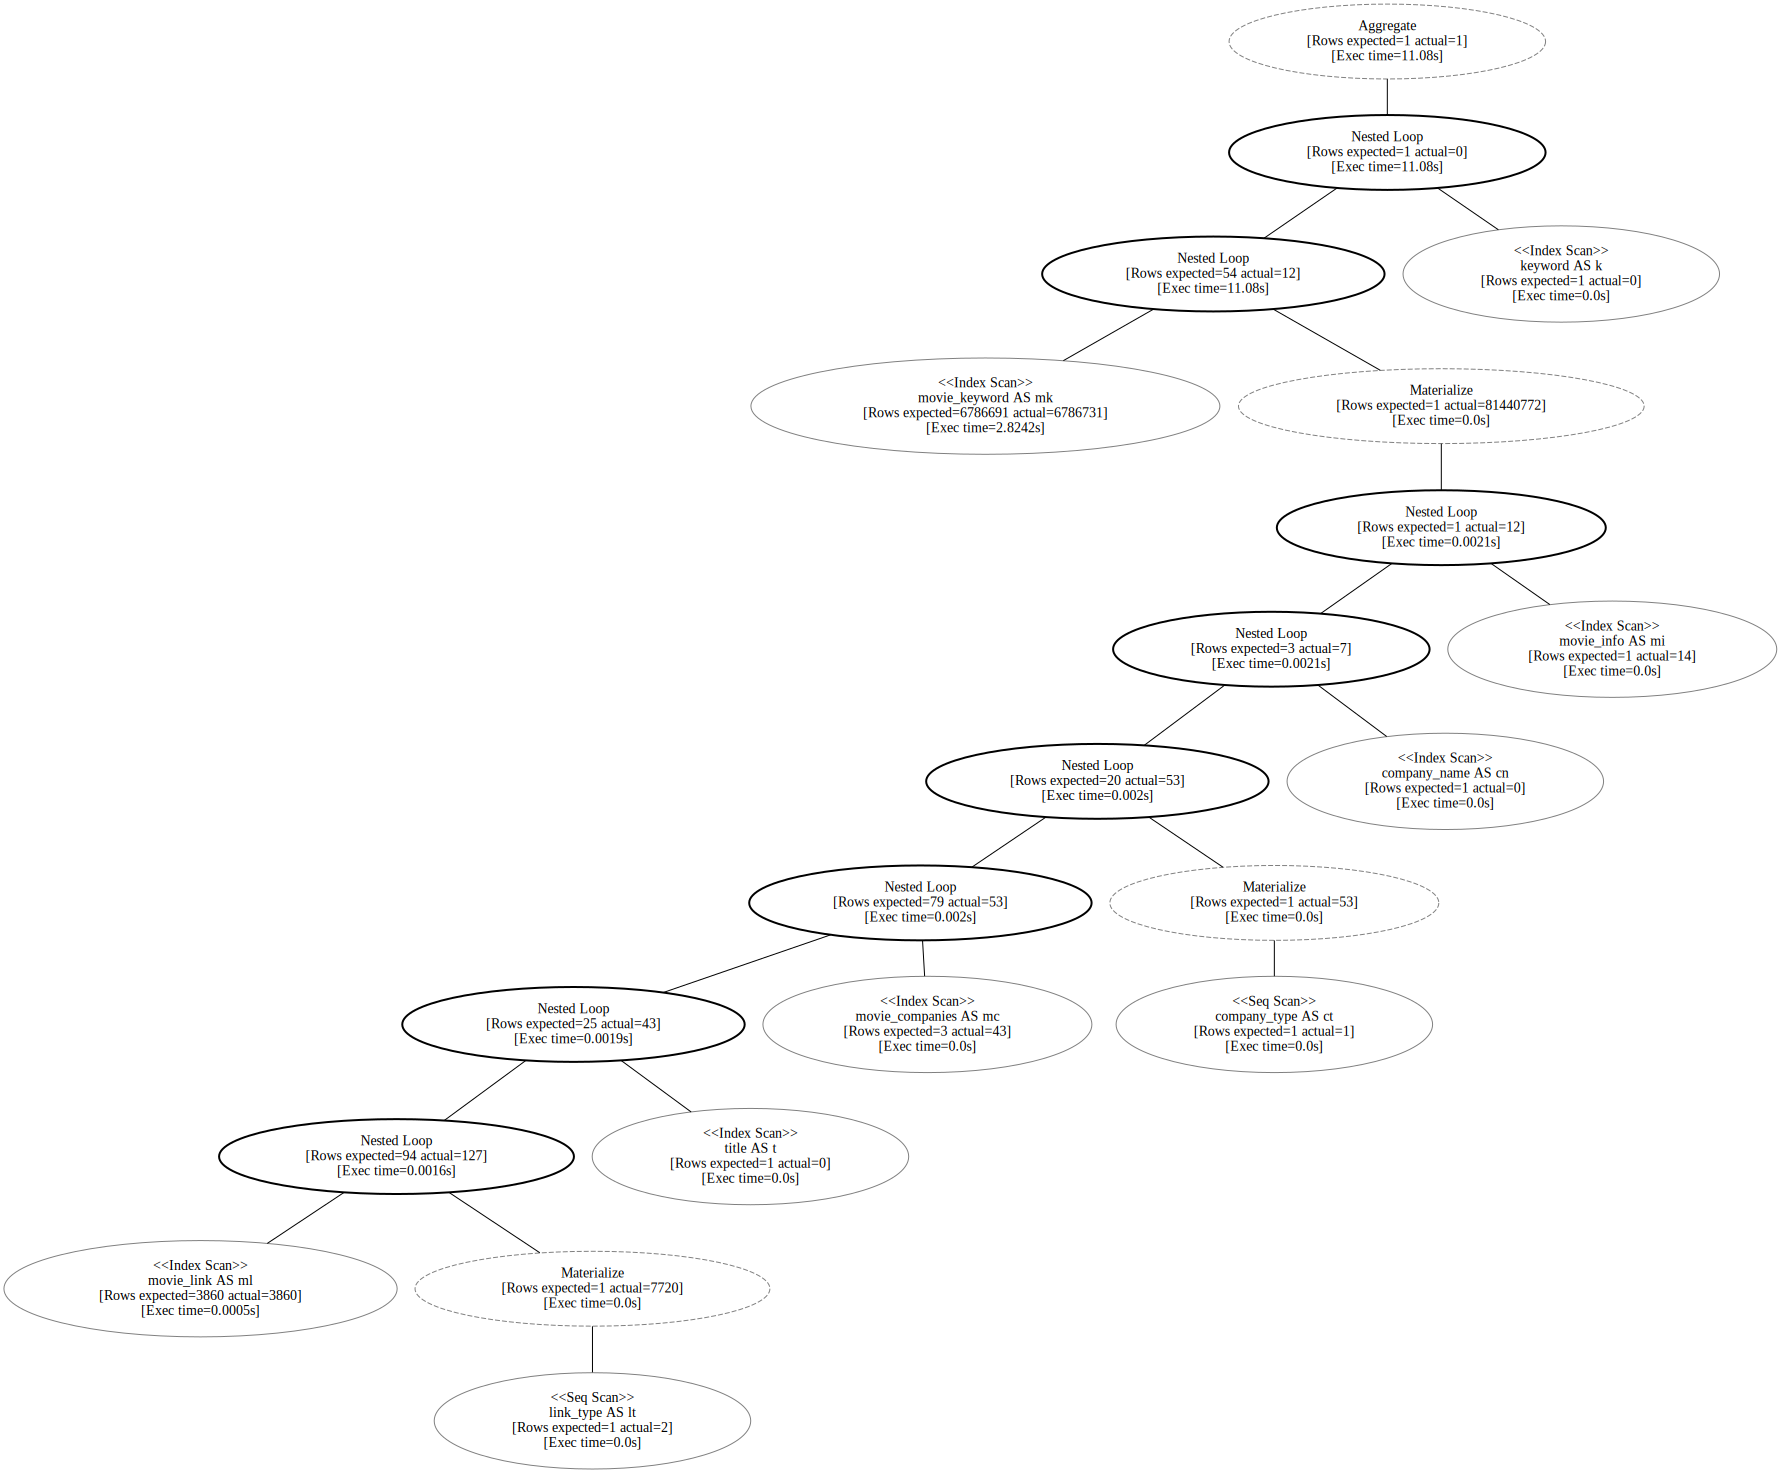

In [18]:
pre_plan = db_vis.plot_analyze_plan(pre_jump["query_plan"].as_query_execution_plan())
pre_plan.render(outfile="plots/plan-21b-70pct-ssd.pdf", format="pdf")
pre_plan

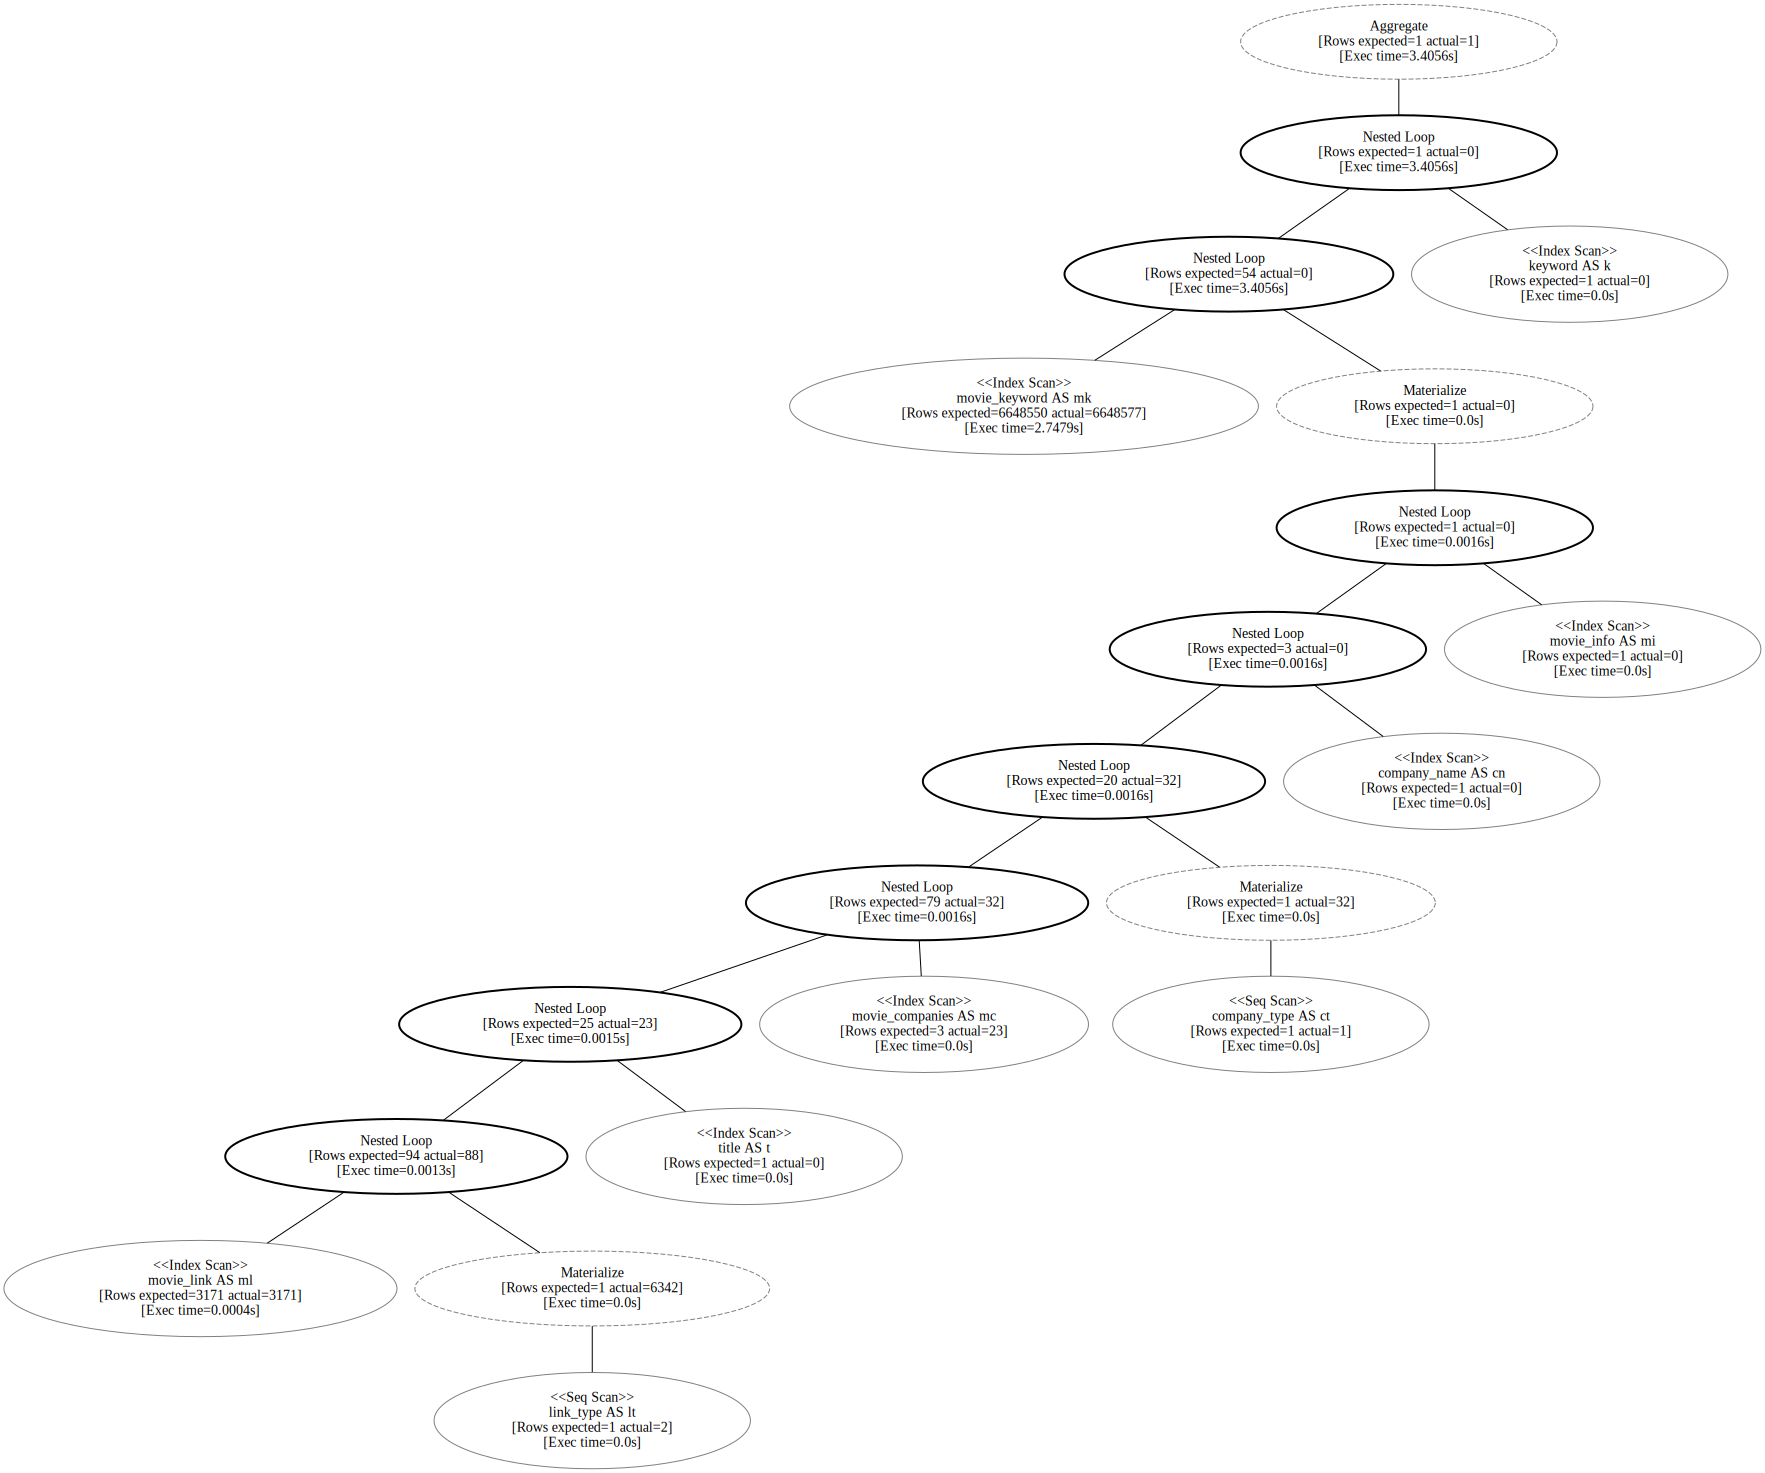

In [19]:
post_plan = db_vis.plot_analyze_plan(post_jump["query_plan"].as_query_execution_plan())
post_plan.render(outfile="plots/plan-21b-75pct-ssd.pdf", format="pdf")
post_plan

## Figure 14: Correlation between $C_{out}$ increase and runtime increase

In [20]:
df_job["c_out"] = df_job["query_plan"].map(lambda plan: plan.total_processed_rows() if plan else np.nan)

def determine_cout_rt_increases(sample: pd.DataFrame) -> pd.DataFrame:
    sample = sample.sort_values(by="fill_ratio").reset_index(drop=True)
    rt_increases = sample["total_runtime"].shift(-1) - sample["total_runtime"]
    cout_increases = sample["c_out"].shift(-1) - sample["c_out"]
    return pd.DataFrame(dict(fill_ratio=sample["fill_ratio"], runtime_increase=rt_increases, cout_increase=cout_increases))

def make_cout_rt_corr_df(df: pd.DataFrame) -> pd.DataFrame:
    return (df
            .groupby("label", observed=True)
            .apply(determine_cout_rt_increases, include_groups=False)
            .reset_index(drop=False)  # restore our labels
            .drop(columns="level_1"))


def make_cout_rt_corr_plot(df: pd.DataFrame, jumping_queries: set[str], *, out: str) -> None:
    corr_df = make_cout_rt_corr_df(df).query("label.isin(@jumping_queries)")

    fig, ax = plt.subplots(figsize=(8, 4))
    g = sns.scatterplot(corr_df, x="cout_increase", y="runtime_increase",
                        ax=ax)
    g.set_xscale("log")
    g.set_yscale("log")
    g.set(xlabel="$C_{out}$ increase [tuples]", ylabel="Runtime increase [s]")

    fig.tight_layout()
    fig.savefig(out)

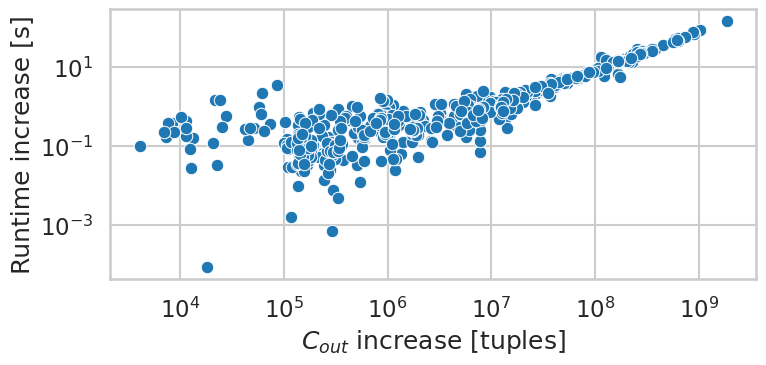

In [21]:
jumps_ssd = jumps_job.query("server == 'ssd' & slowdown >= 1.3 & rt_diff >= 1")["label"].unique()
make_cout_rt_corr_plot(df_job.query("server == 'ssd' & plan_type == 'native-fixed' & ~timeout"), set(jumps_ssd),
                       out="plots/data-shift-cout-corr.pdf")

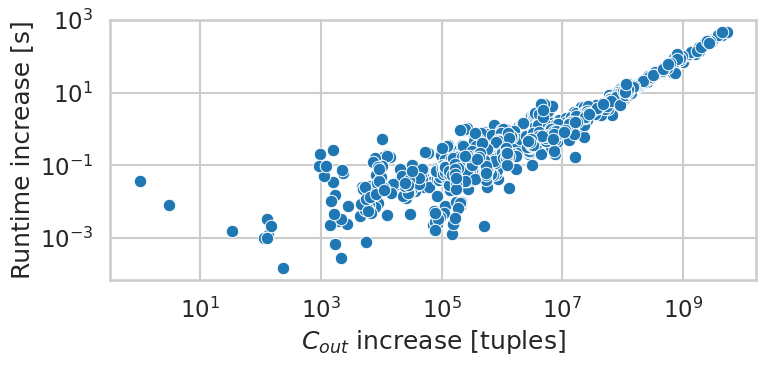

In [22]:
jumps_hdd = jumps_job.query("server == 'hdd' & slowdown >= 1.3 & rt_diff >= 1")["label"].unique()
make_cout_rt_corr_plot(df_job.query("server == 'hdd' & plan_type == 'native-fixed'"), set(jumps_hdd),
                       out="plots/data-shift-cout-corr-hdd.pdf")

## Stats benchmark

In [23]:
shifting_queries = (jumps_stats
                    .query("rt_diff >= 1")
                    .drop_duplicates(subset=["label"], keep="first"))
monotonic_queries = (df_stats
                     .groupby(["server", "label", "plan_type"], as_index=False, observed=True)
                     .agg(monotonicity_violation=pd.NamedAgg(column="total_runtime",
                                                             aggfunc=lambda runtimes: (runtimes < 0.95 * runtimes.shift(-1)).any()))
                     .groupby(["label"], as_index=False, observed=True)
                     .agg(monotonicity_violation=pd.NamedAgg(column="monotonicity_violation", aggfunc="any"))
                     .query("~monotonicity_violation"))
relevant_queries = (df_stats
                    .merge(shifting_queries[["label"]], on=["label"])
                    .merge(monotonic_queries[["label"]], on=["label"])

)

**Only a few queries can be analyzed meaningfully:**

In [24]:
relevant_queries["label"].unique()

['q-47', 'q-49', 'q-120', 'q-122', 'q-131', 'q-135']
Categories (146, object): ['q-1' < 'q-2' < 'q-3' < 'q-4' ... 'q-143' < 'q-144' < 'q-145' < 'q-146']

**The few relevant queries exhibit similar behavior compared to the JOB queries:**

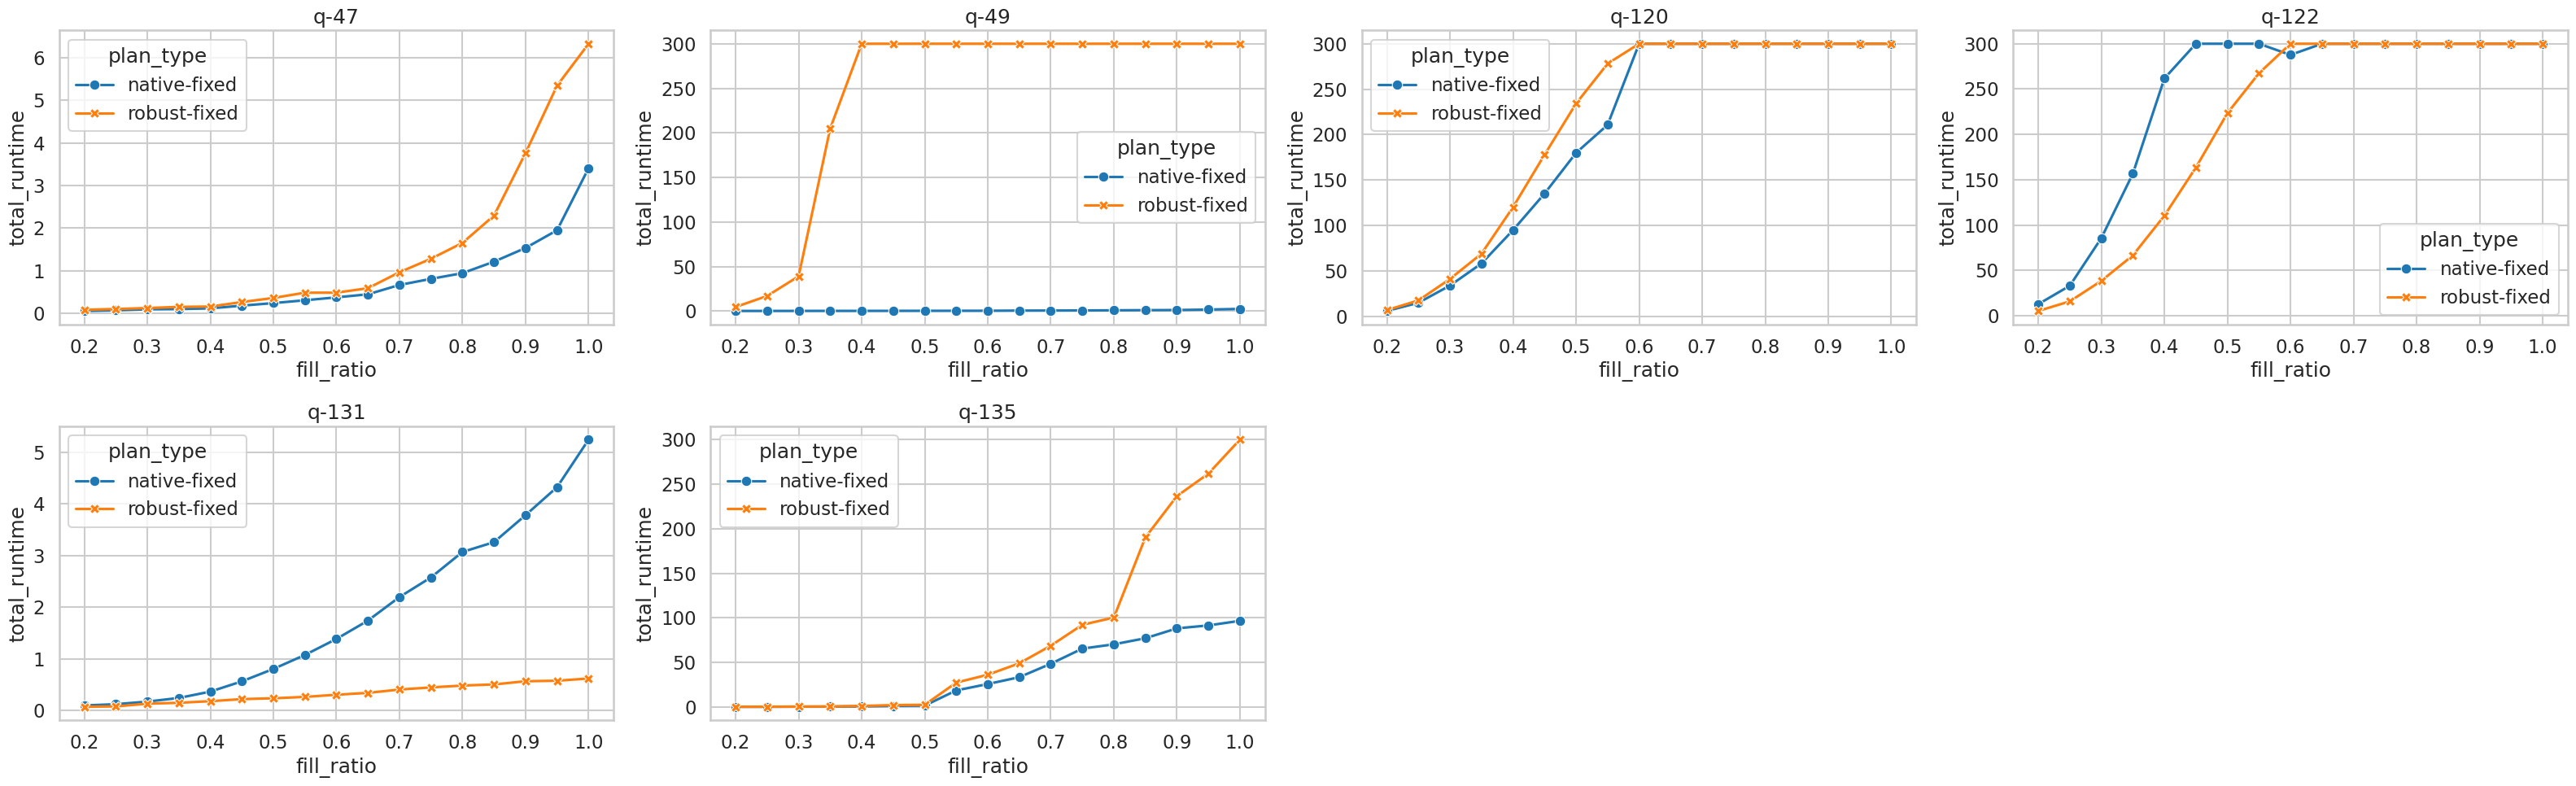

In [25]:
def make_quick_stats_plot(label, df, ax) -> None:
    g = sns.lineplot(df, x="fill_ratio", y="total_runtime",
                     hue="plan_type", style="plan_type",
                     markers=True, dashes=False,
                     ax=ax)
    g.set(title=label)

fig, _  = plots.make_grid_plot(relevant_queries, plot_func=make_quick_stats_plot, base_widht=8, base_height=5)
fig.tight_layout()